# Fragment Mech Simulation with Reattachment

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rmgpy.chemkin import *
from rmgpy.species import Species

In [3]:
from afm.simulator import OdeSimulator
import afm.utils
import afm.simulator

/home/yentingw/RMG/RMG-Py/rmgpy/tools/plot.py:31: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/yentingw/anaconda2/envs/rmg_env/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/yentingw/anaconda2/envs/rmg_env/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/yentingw/anaconda2/envs/rmg_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/yentingw/anaconda2/envs/rmg_env/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/yentingw/anaconda2/envs/rmg_env/lib/pyth

## 1. specify condition and simulate

In [4]:
temperature = 673.15 # K
pressure = 350*3.75 # bar

initial_mol_fraction = {
    "ArCCCCR":1.0,
    "LCCCCR":1.75,
    "LC":1.0
}

termination_time = 3600*14 # hrs

In [5]:
model = 'two-sided'

working_dir = os.path.join('../', 'data', 'pdd_chemistry', model)
chemkin_path = os.path.join(working_dir, 'chem_annotated.inp')
species_dict_path = os.path.join(working_dir, 'species_dictionary.txt')
smiles_dict_path = os.path.join(working_dir, 'fragment_smiles.txt')

In [6]:
ode_simulator = OdeSimulator(chemkin_path,
                             species_dict_path,
                             smiles_dict_path,
                             temperature,
                             pressure)

In [7]:
alldata = ode_simulator.simulate(initial_mol_fraction, termination_time)

In [8]:
results_path = os.path.join(working_dir, 'results')
if not os.path.exists(results_path):
    os.mkdir(results_path)

## 2. reactant conversion

In [9]:
# prepare moles data
time, dataList, _ = alldata[0]
TData = dataList[0]
PData = dataList[1]
VData = dataList[2]
total_moles = PData.data*VData.data/8.314/TData.data

moles_dict = {}
for data in dataList[3:]:
    spe_label = data.label
    moles_dict[spe_label] = max(data.data[-1]*total_moles[-1],0)

In [10]:
ArCCCCR_mf = dataList[3].data
print dataList[3].label
ArCCCCR_moles = ArCCCCR_mf*total_moles
ArCCCCR_conv = (ArCCCCR_moles[0]-ArCCCCR_moles)/ArCCCCR_moles[0]

ArCCCCR


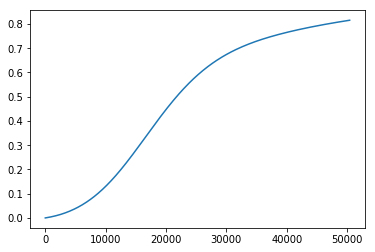

In [11]:
plt.plot(time.data, ArCCCCR_conv)
numpy.savetxt(os.path.join(results_path, 'reactant_conv.csv'), (time.data, ArCCCCR_conv))

## 3. molecular weight distribution

In [12]:
fragmental_weight_distri = ode_simulator.get_molecular_weight_distribution(alldata)

In [13]:
mws = [tup[0]*1000 for tup in fragmental_weight_distri]
moles = [tup[1] for tup in fragmental_weight_distri]

molefracs = moles/sum(moles)

In [14]:
numpy.savetxt(os.path.join(results_path, 'mwd.csv'), (mws, molefracs))